In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pickle
from scipy.optimize import minimize
import spin_package.spherical_fixed_T as spherical_T
import spin_package.utils as sp_utils

%load_ext autoreload
%autoreload 2

## State Following Fixed Temperatures

In [2]:
p = 3
n_points_m = 100
n_points_less_T = 1
n_points_T = 1
n_points_more_T = 10

T_kauz, T_dyn = sp_utils.get_Tk_Td(p, model="spherical")

Teqs = np.hstack(
    (
        (T_kauz - (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_less_T + 1))[::-1],
        np.linspace(T_kauz, T_dyn, n_points_T + 1),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1),
    )
)
T_planting = T_kauz
J0 = 0.5 / T_planting

m2i = 0.9
q2i = 0.9

In [3]:
ms = np.linspace(0.0, 0.9, n_points_m)
q_old = 0.9
all_data = {}

for jdx, T in enumerate(tqdm(Teqs, desc="RS")):
    data = sp_utils.observables(["q", "m", "f"], (n_points_m,))
    total_file_name = "../data/spherical/" + sp_utils.get_file_name_T_sweep_m(
        "spherical", p, T_planting, T, ms
    )
    if os.path.exists(total_file_name):
        with open(total_file_name, "rb") as f:
            data = pickle.load(f)
    else:
        for idx, m in enumerate(tqdm(ms, desc="m", leave=False)):
            q = spherical_T.fixed_points_q_J0(m, 1/T, p, blend=0.95, q_init=q_old)
            data["q"][idx] = q
            data["m"][idx] = m
            data["f"][idx] = spherical_T.f_FP_J0(q, m, p, 1/T, J0)

            q_old = q

        with open(total_file_name, "wb") as f:
            pickle.dump(data, f)

    all_data[T] = data

print("Data is saved.")

RS:   0%|          | 0/13 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

Data is saved.


In [4]:
m0, q0 = 0.9, 0.9
blend = 0.1
total_file_name = "../data/spherical/" + sp_utils.get_file_name_sweep_T(
    "spherical", p, T_planting, Teqs, m0, q0
)
if os.path.exists(total_file_name):
    print("Data is already saved.")
    with open(total_file_name, "rb") as f:
        data_fixed_point = pickle.load(f)

    print("Data is loaded.")
else:
    print("Data is not saved.")
    data_fixed_point = sp_utils.observables(["T", "q", "m", "f", "e"], (len(Teqs),))
    for i, T in enumerate(tqdm(Teqs)):
        m, q = m0, q0
        err = 1
        while err > 1e-7:
            m_new = spherical_T.newm(m, q, p, 1/T)
            q_new = spherical_T.newq(m, q, p, 1/T, J0)

            err = max(abs(q_new - q), abs(m_new - m))
            m = blend * m + (1 - blend) * m_new
            q = blend * q + (1 - blend) * q_new

        data_fixed_point["T"][i] = T
        data_fixed_point["m"][i] = m
        data_fixed_point["q"][i] = q
        data_fixed_point["f"][i] = spherical_T.f_FP_J0(q, m, p, 1/T, J0)
        data_fixed_point["e"][i] = spherical_T.e_J0(q, m, p, 1/T, J0)

    with open(total_file_name, "wb") as f:
        pickle.dump(data_fixed_point, f)

    print("Data is saved.")

Data is not saved.


  0%|          | 0/13 [00:00<?, ?it/s]

Data is saved.


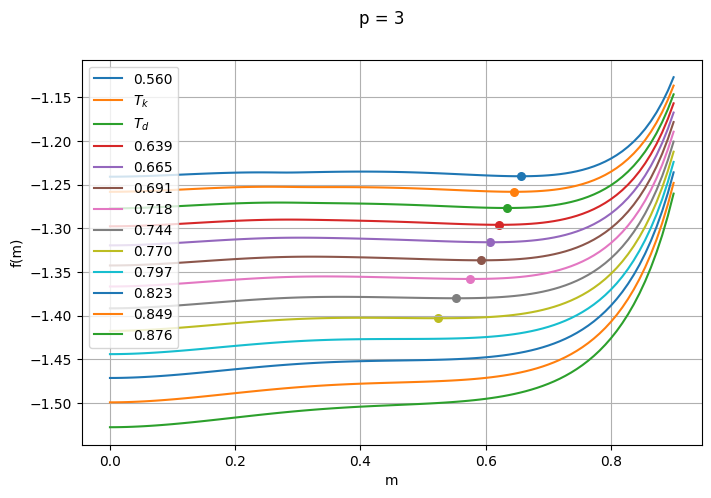

In [5]:
plt.figure(figsize=(8,5))
plt.suptitle(f"p = {p:d}")
for i, T in enumerate(Teqs):
    legend_name = sp_utils.legend_name_Tk_Td_T(T, T_kauz, T_dyn)

    data = all_data[T]
    plt.plot(data['m'], data['f'], label=legend_name, color=f'C{i}')

    plt.scatter(data_fixed_point['m'][i], data_fixed_point['f'][i], color=f'C{i}', marker='o', s=30)

plt.xlabel('m')
plt.ylabel(r'f(m)')
plt.legend()
plt.grid()


## State Following Untill Losing

In [6]:
p = 100
T_kauz, T_dyn = sp_utils.get_Tk_Td(p, model="spherical")
T_planting = T_kauz
J0 = 0.5 / T_planting

T_start = T_kauz
deltaT = 1e-5
m0, q0 = 0.9, 0.9

In [7]:
blend = 0.1
total_file_name = "../data/spherical/" + sp_utils.get_file_name_until_fail(
    "spherical", p, T_planting, T_start, deltaT, m0, q0
)
if os.path.exists(total_file_name):
    print("Data is already saved.")
    with open(total_file_name, "rb") as f:
        data_fixed_point = pickle.load(f)

    print("Data is loaded.")
else:
    print("Data is not saved.")
    tmp_T, tmp_m, tmp_q, tmp_f, tmp_e = [], [], [], [], []
    cur_T = T_start
    m, q = m0, q0
    while True:
        print(f"T = {cur_T:.3f}, m = {m:.3f}, q = {q:.3f}")
        err = 1
        while err > 1e-7:
            m_new = spherical_T.newm(m, q, p, 1/cur_T)
            q_new = spherical_T.newq(m, q, p, 1/cur_T, J0)

            err = max(abs(q_new - q), abs(m_new - m))
            m = blend * m + (1 - blend) * m_new
            q = blend * q + (1 - blend) * q_new
        print(f"T = {cur_T:.3f}, m = {m:.3f}, q = {q:.3f}")
        if abs(m) < 1e-7:
            break
        elif not (abs(m) < 1):
            break
        else:
            tmp_T.append(cur_T)
            tmp_m.append(m)
            tmp_q.append(q)
            tmp_f.append(spherical_T.f_FP_J0(q, m, p, 1/cur_T, J0))
            tmp_e.append(spherical_T.e_J0(q, m, p, 1/cur_T, J0))

            cur_T += deltaT

    data_fixed_point = sp_utils.observables(["T", "q", "m", "f", "e"], (len(tmp_T),))
    data_fixed_point["T"] = np.array(tmp_T)
    data_fixed_point["m"] = np.array(tmp_m)
    data_fixed_point["q"] = np.array(tmp_q)
    data_fixed_point["f"] = np.array(tmp_f)
    data_fixed_point["e"] = np.array(tmp_e)

    with open(total_file_name, "wb") as f:
        pickle.dump(data_fixed_point, f)

    print("Data is saved.")

Data is not saved.
T = 0.280, m = 0.900, q = 0.900
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998, q = 0.998
T = 0.280, m = 0.998,

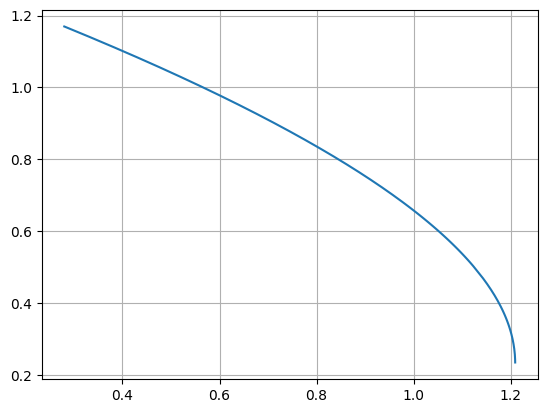

In [9]:
plt.plot(data_fixed_point['T'], data_fixed_point['e'], label='m')
plt.grid()
#plt.xscale('log')
#plt.yscale('log')

## $T_d^+(p)$ from State Following

In [10]:
p_tab = np.arange(3,40) # np.linspace(3, 100, 20, dtype=int)
deltaT = 1e-5
m0, q0 = 0.9, 0.9
blend = 0.4

total_file_name = "../data/spherical/" + sp_utils.get_file_name_Tdplus_Tk(
        "spherical", deltaT, m0, q0, p_tab[0], p_tab[-1], len(p_tab)
    )
if os.path.exists(total_file_name):
    print("Data is already saved.")
    with open(total_file_name, "rb") as f:
        data_Td_plus = pickle.load(f)

    print("Data is loaded.")
else:
    print("Data is not saved.")
    tmp_T, tmp_m, tmp_q, tmp_f, tmp_e = [], [], [], [], []
    for p in p_tab:
        T_kauz, T_dyn = sp_utils.get_Tk_Td(p, model="spherical")
        T_planting = T_kauz
        J0 = 0.5 / T_planting
        T_start = T_kauz

        cur_T = T_start
        m, q = m0, q0
        while True:
            print(f"T = {cur_T:.3f}")
            err = 1
            while err > 1e-7:
                m_new = spherical_T.newm(m, q, p, 1/cur_T)
                q_new = spherical_T.newq(m, q, p, 1/cur_T, J0)

                err = max(abs(q_new - q), abs(m_new - m))
                m = blend * m + (1 - blend) * m_new
                q = blend * q + (1 - blend) * q_new

            if abs(m) < 1e-7:
                break
            elif not (abs(m) < 1):
                break
            else:
                cur_T += deltaT
        tmp_T.append(cur_T)
        tmp_m.append(m)
        tmp_q.append(q)
        tmp_f.append(spherical_T.f_FP_J0(q, m, p, 1/cur_T, J0))
        tmp_e.append(spherical_T.e_J0(q, m, p, 1/cur_T, J0))
    data_Td_plus = sp_utils.observables(["p","T", "q", "m", "f", "e"], (len(tmp_T),))
    data_Td_plus["p"] = np.array(p_tab)
    data_Td_plus["T"] = np.array(tmp_T)
    data_Td_plus["m"] = np.array(tmp_m)
    data_Td_plus["q"] = np.array(tmp_q)
    data_Td_plus["f"] = np.array(tmp_f)
    data_Td_plus["e"] = np.array(tmp_e)

    with open(total_file_name, "wb") as f:
        pickle.dump(data_Td_plus, f)

    print("Data is saved.")

Data is already saved.
Data is loaded.


In [24]:
Tds = np.empty(len(p_tab))
Tks = np.empty(len(p_tab))

for i, p in enumerate(p_tab):
    Tks[i], Tds[i] = sp_utils.get_Tk_Td(p, model="spherical")

In [25]:
tdplus = data_Td_plus["T"]
last_points = 10
poly_coeff = np.polyfit(
    np.sqrt(np.log(p_tab[-last_points:])), tdplus[-last_points:], 1
)
print(f"poly_coeff = {poly_coeff}")
poly_fitted = np.poly1d(poly_coeff)

poly_coeff = [0.50664753 0.11703225]


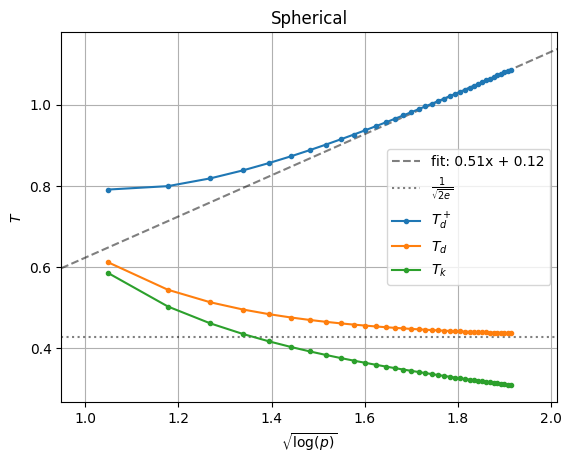

In [33]:
xs = np.linspace(
    np.min(np.sqrt(np.log(p_tab))) - 0.1, np.max(np.sqrt(np.log(p_tab))) + 0.1, 100
)

plt.plot(
    xs,
    poly_fitted(xs),
    "k--",
    label=f"fit: {poly_coeff[0]:.2f}x + {poly_coeff[1]:.2f}",
    alpha=0.5,
)
plt.plot(xs, np.ones_like(xs)/ np.sqrt(2 * np.exp(1)), 'k:', label=r'$\frac{1}{\sqrt{2e}}$', alpha=0.5)

plt.plot(np.sqrt(np.log(data_Td_plus['p'])), data_Td_plus['T'], label=r'$T_d^+$', marker='.')
plt.plot(np.sqrt(np.log(p_tab)), Tds, label=r'$T_d$', marker='.')
plt.plot(np.sqrt(np.log(p_tab)), Tks, label=r'$T_k$', marker='.')

plt.title('Spherical')
plt.xlabel('$\\sqrt{\\log(p)}$')
plt.ylabel(r'$T$')
plt.legend()
plt.xlim(np.min(xs), np.max(xs))
plt.grid()